In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('cars.csv')
data.head(5)

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [3]:
#saving columns names and number of them 
n_cols = data.shape[1]
col_names = data.columns
col_names

Index(['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',
       ' year', ' brand'],
      dtype='object')

In [4]:
data.columns = data.columns.str.lstrip(' ')
missing_count = data.isnull().sum()
missing_count[0:n_cols]

mpg            0
cylinders      0
cubicinches    0
hp             0
weightlbs      0
time-to-60     0
year           0
brand          0
dtype: int64

In [5]:
data2 = data.copy()
data['brand'].unique()

array([' US.', ' Europe.', ' Japan.'], dtype=object)

In [6]:
one_hot = pd.get_dummies(data['brand'])
data = pd.concat([data, one_hot], axis=1)
data = data.drop(['brand'], axis=1)

In [7]:
data

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,Europe.,Japan.,US.
0,14.0,8,350,165,4209,12,1972,0,0,1
1,31.9,4,89,71,1925,14,1980,1,0,0
2,17.0,8,302,140,3449,11,1971,0,0,1
3,15.0,8,400,150,3761,10,1971,0,0,1
4,30.5,4,98,63,2051,17,1978,0,0,1
...,...,...,...,...,...,...,...,...,...,...
256,17.0,8,305,130,3840,15,1980,0,0,1
257,36.1,4,91,60,1800,16,1979,0,1,0
258,22.0,6,232,112,2835,15,1983,0,0,1
259,18.0,6,232,100,3288,16,1972,0,0,1


In [8]:
data2['brand'] = data2['brand'].replace(' US.',0).replace(' Europe.',1).replace(' Japan.',2).astype(int)
#data2['brand']=data2['brand'].replace({' US.':0,' Europe.':1,' Japan.':2}).astype(int)
data2

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,0
1,31.9,4,89,71,1925,14,1980,1
2,17.0,8,302,140,3449,11,1971,0
3,15.0,8,400,150,3761,10,1971,0
4,30.5,4,98,63,2051,17,1978,0
...,...,...,...,...,...,...,...,...
256,17.0,8,305,130,3840,15,1980,0
257,36.1,4,91,60,1800,16,1979,2
258,22.0,6,232,112,2835,15,1983,0
259,18.0,6,232,100,3288,16,1972,0


In [9]:
data2.dtypes

mpg            float64
cylinders        int64
cubicinches     object
hp               int64
weightlbs       object
time-to-60       int64
year             int64
brand            int32
dtype: object

In [10]:
data2['cubicinches'].unique()

array(['350', '89', '302', '400', '98', '351', '440', '183', '108', '97',
       '225', '85', '304', '113', '107', '86', '121', '200', '91', '71',
       '250', '120', '199', '231', '80', '232', ' ', '455', '318', '122',
       '141', '340', '116', '156', '90', '360', '168', '305', '198',
       '112', '119', '262', '134', '429', '115', '72', '105', '151', '88',
       '307', '101', '79', '140', '114', '173', '144', '81', '267', '70',
       '163', '171', '260', '131', '68', '96', '135', '390', '146', '258',
       '83', '76', '383', '130', '110', '454'], dtype=object)

In [11]:
data2 = data2.dropna()
data2 = data2[pd.to_numeric(data2['cubicinches'], errors='coerce').notna()]
data2 = data2[pd.to_numeric(data2['weightlbs'], errors='coerce').notna()]
data2 = data2.astype(int)
data2.dtypes

mpg            int32
cylinders      int32
cubicinches    int32
hp             int32
weightlbs      int32
time-to-60     int32
year           int32
brand          int32
dtype: object

In [12]:
data2.columns

Index(['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time-to-60',
       'year', 'brand'],
      dtype='object')

In [13]:
x_cols = ['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time-to-60','year']
x = data2.iloc[:,:-1].values
#x = pd.DataFrame(x, columns=x_cols)
#x = data2.drop(columns={'brand'})
y = data2['brand'].to_numpy()

In [14]:
n = 10
kf =  KFold(n_splits=n, shuffle=True, random_state=42)
model = DecisionTreeClassifier(random_state=42)
train_indices = []
test_indices = []
scores = np.zeros(n)


for train_index, test_index in kf.split(x):
    train_indices.append(train_index)
    test_indices.append(test_index)

# من اول هنا ممكن نبدلها بالتانية
for i in range(n):
    x_train = x[train_indices[i], :]
    y_train = y[train_indices[i]]
    x_test = x[test_indices[i], :]
    y_test = y[test_indices[i]]
    model.fit(x_train, y_train)
    scores[i] = model.score(x_test, y_test)
    print (f'folds = {i+1} : score = {scores[i]}')

folds = 1 : score = 0.7307692307692307
folds = 2 : score = 0.8076923076923077
folds = 3 : score = 0.7307692307692307
folds = 4 : score = 0.7692307692307693
folds = 5 : score = 0.9230769230769231
folds = 6 : score = 0.8076923076923077
folds = 7 : score = 0.84
folds = 8 : score = 0.8
folds = 9 : score = 0.76
folds = 10 : score = 0.76


In [15]:
#another simplest way to do it 
from sklearn.model_selection import cross_val_score as cv
cv(model,x,y,cv=kf)

array([0.73076923, 0.80769231, 0.73076923, 0.76923077, 0.92307692,
       0.80769231, 0.84      , 0.8       , 0.76      , 0.76      ])

In [16]:
#trying to split the k that gives us the best score
best_i= scores.argmax()
train_i, test_i = list(kf.split(x))[best_i]
x_train ,y_train = x[train_i],y[train_i]
x_test,y_test = x[test_i],y[test_i]
model.fit(x_train, y_train)
y_pred =model.predict(x_test)
model.score(x_test, y_test)

0.9230769230769231

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.50      0.67         4
           2       0.80      1.00      0.89         4

    accuracy                           0.92        26
   macro avg       0.92      0.83      0.84        26
weighted avg       0.93      0.92      0.91        26



In [18]:
model.tree_.node_count, model.tree_.max_depth

(67, 11)

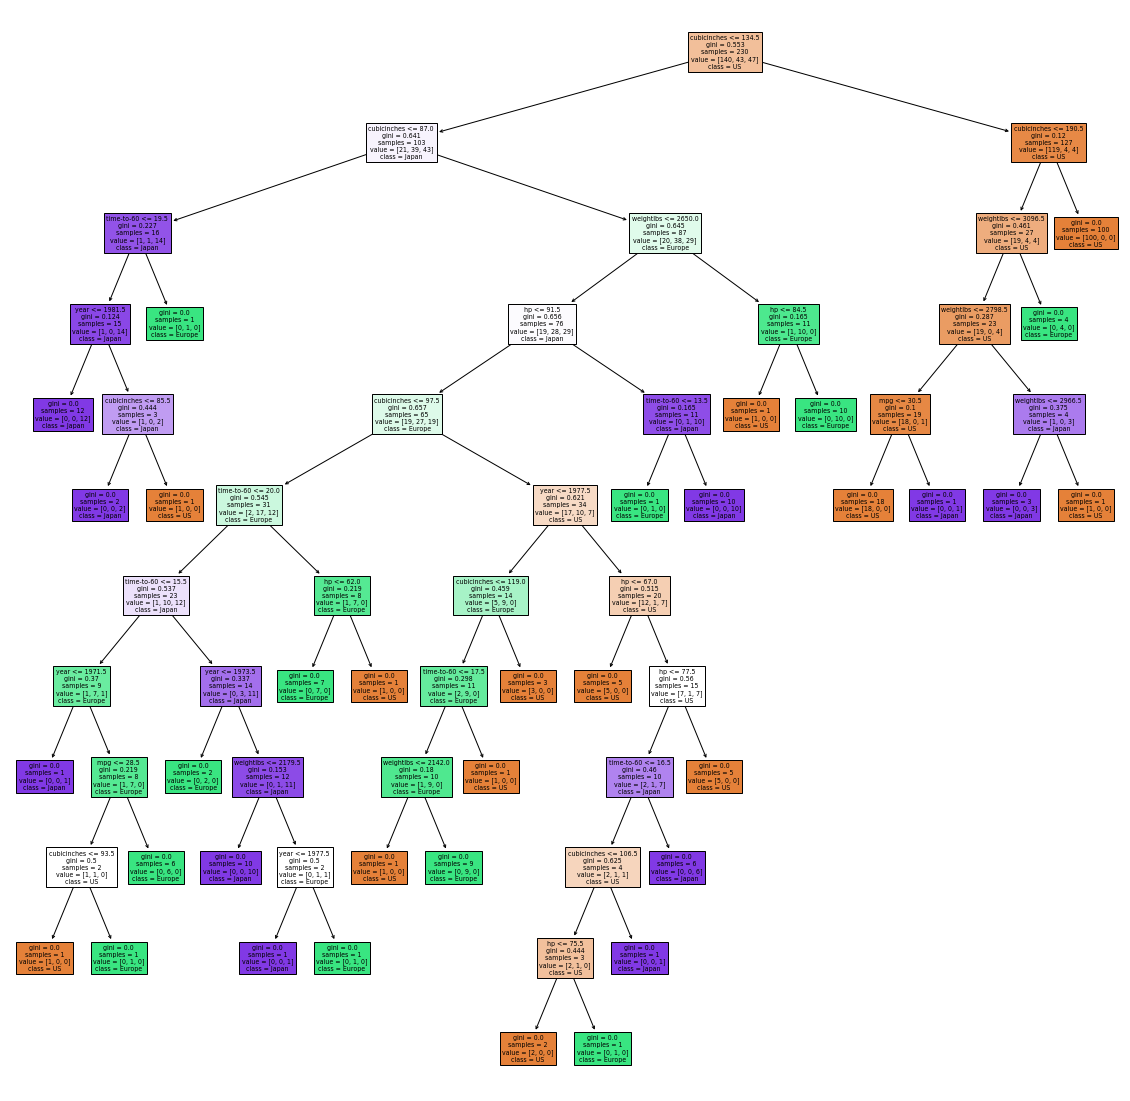

In [55]:
plt.figure(figsize=(20,20))
toto =tree.plot_tree(model,feature_names=x_cols,filled=True, class_names=['US', 'Europe', 'Japan'])
plt.show()

In [20]:
param_grid = {"criterion":["gini","entropy" ],'max_depth':range(1, model.tree_.max_depth+1, 2),
              'max_features': range(1, len(model.feature_importances_)+1),"splitter": ["best", "random"]}
GR = GridSearchCV(model,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=15,
    refit='best_score_'
)
GR = GR.fit(x_train, y_train)

In [21]:
GR.best_score_

0.8561111111111113

In [22]:
GR.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 6, 'splitter': 'best'}

In [23]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(75, 9)

In [24]:
y_test_pred_gr = GR.predict(x_test)
print(classification_report(y_test,y_test_pred_gr))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.33      0.25      0.29         4
           2       0.60      0.75      0.67         4

    accuracy                           0.77        26
   macro avg       0.61      0.63      0.61        26
weighted avg       0.76      0.77      0.76        26



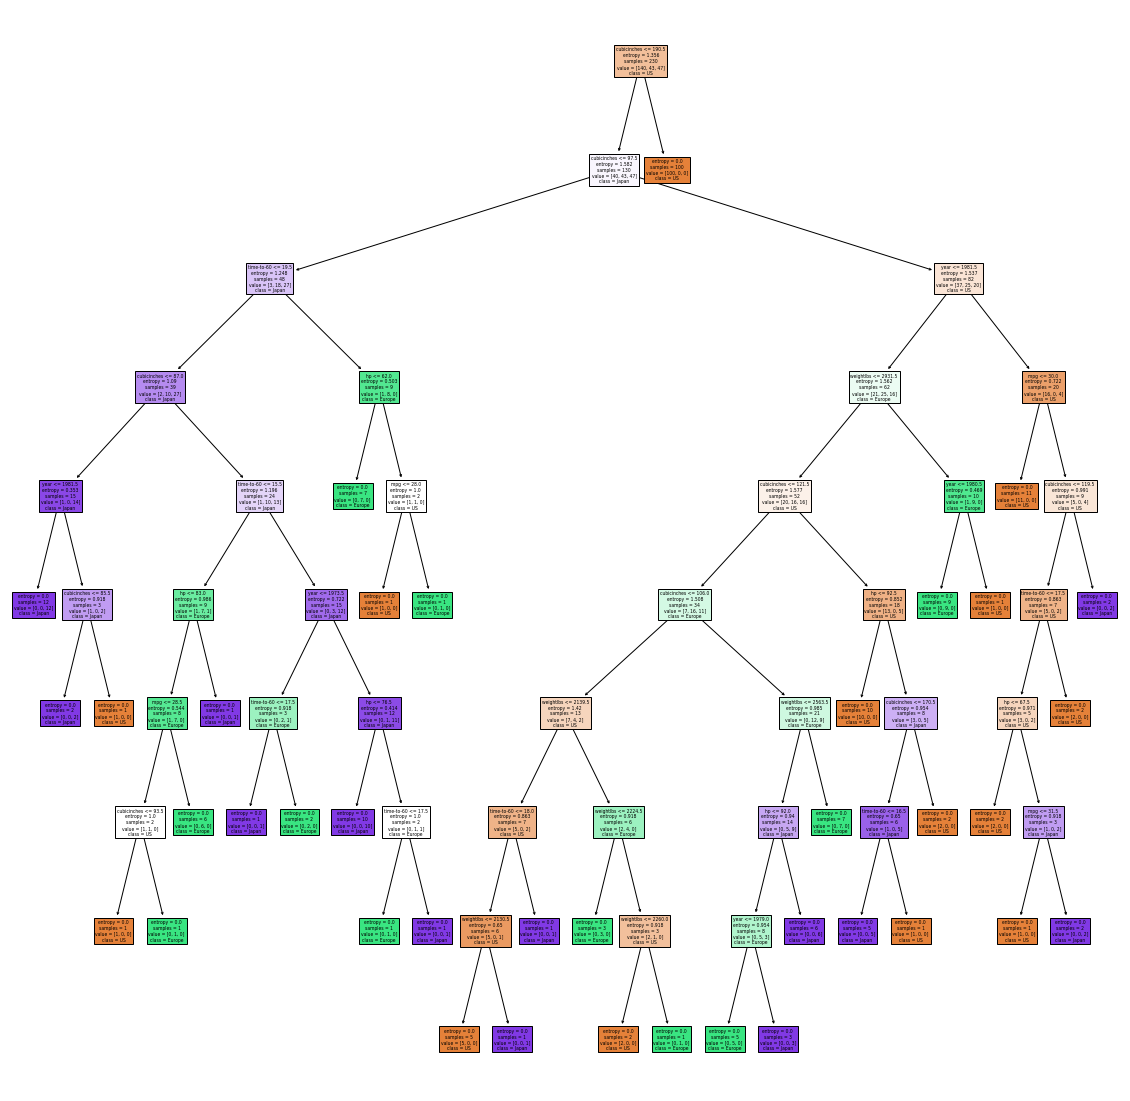

In [54]:
plt.figure(figsize=(20,20))
toto =tree.plot_tree(GR.best_estimator_,feature_names=x_cols,filled=True, class_names=['US', 'Europe', 'Japan'])
plt.show()

In [26]:
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [5],
    "max_features": randint(1, len(model.feature_importances_) + 1),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
}

rs = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring="accuracy",
    cv=15,
    n_iter=50,
    n_jobs=-1,
    refit="best_score_",
    random_state=42,
)

rs.fit(x_train, y_train)

RandomizedSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EB7BEAB520>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EB7BEAB550>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EB7BD7C1F0>,
                                        'splitter': ['best', 'random']},
                   random_state=42, refit='best_score_', scoring='accuracy')

In [27]:
rs.best_score_

0.8050000000000002

In [28]:
rs.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'best'}

In [37]:
rs.best_estimator_.tree_.node_count, rs.best_estimator_.tree_.max_depth

(23, 5)

In [30]:
y_test_pred_rs = rs.predict(x_test)
print(classification_report(y_test,y_test_pred_rs))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.33      0.25      0.29         4
           2       0.50      0.25      0.33         4

    accuracy                           0.69        26
   macro avg       0.53      0.46      0.48        26
weighted avg       0.66      0.69      0.66        26



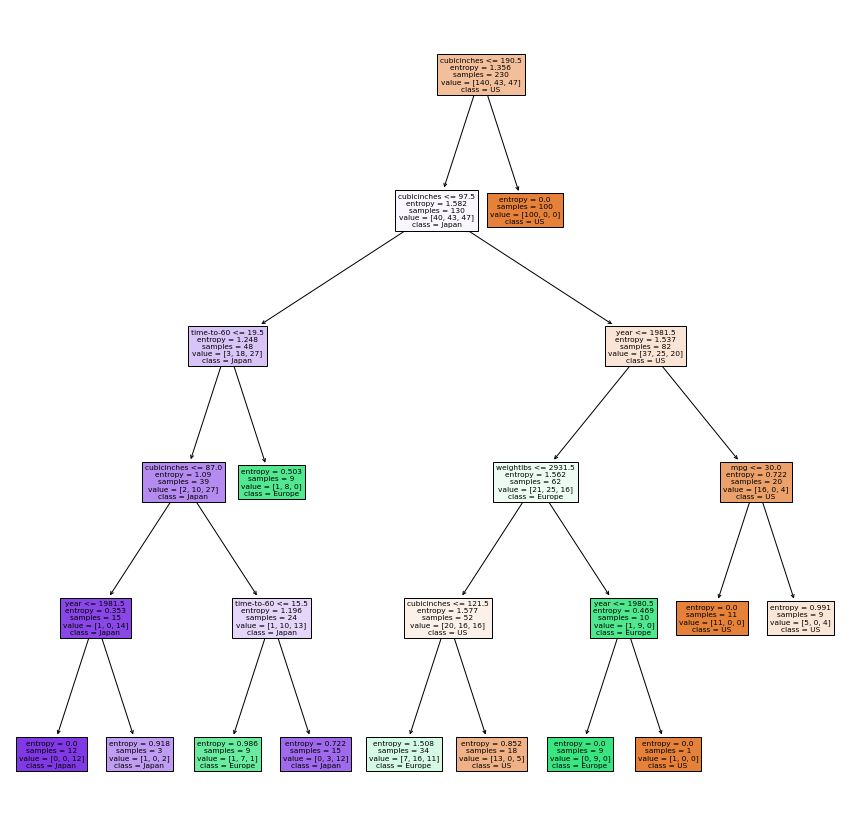

In [52]:
plt.figure(figsize=(15,15))
toto =tree.plot_tree(rs.best_estimator_,feature_names=x_cols,filled=True, class_names=['US', 'Europe', 'Japan'])
plt.show()

In [42]:
pipe = Pipeline([
    ('scaler',MinMaxScaler()),
    ('classifier', DecisionTreeClassifier())
       ])

In [43]:
param_grid = [
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': range(1, model.tree_.max_depth+1, 2),
        'scaler': [StandardScaler(), 'passthrough']
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__learning_rate': [0.1, 0.3, 1],
        'classifier__n_estimators': [50, 100, 200],
        'scaler': [StandardScaler(), 'passthrough']
    }
]


grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=15)
grid_search.fit(x, y)

GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth': range(1, 12, 2),
                          'scaler': [StandardScaler(), 'passthrough']},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__learning_rate': [0.1, 0.3, 1],
                          'classifier__n_estimators': [50, 100, 200],
                          'scaler': [StandardScaler(), 'passthrough']}])

In [46]:
grid_search.best_score_

0.8677559912854031

In [56]:
grid_search.best_params_

{'classifier': GradientBoostingClassifier(),
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 100,
 'scaler': 'passthrough'}

In [57]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', 'passthrough'),
                ('classifier', GradientBoostingClassifier())])

In [50]:
y_test_pred_pipe = grid_search.predict(x_test)
print(classification_report(y_test,y_test_pred_pipe))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

